<a href="https://colab.research.google.com/github/Ivyson/Neural-Network-XOR/blob/main/RecurrentNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

This session builds upon the progress we made with the **Multi-Layered Perceptron (MLP)** neural network [linked here](https://github.com/Ivyson/Neural-Network-XOR/blob/main/Model.ipynb).
## What is this?

To explain the concept of **Recurrent Neural Networks (RNNs)**, we'll begin with the **unrolled version** to build intuition step by step. Once the structure is clear, we can abstract it using higher-level blocks to represent the full architecture.

To understand RNNs, we first revisit the **Simple Perceptron** - a small network unit that receives an input and performs a weighted sum followed by an activation function:

$$
y_t = f(W \cdot X + b)
$$

Where:

* $W$ is the weight matrix (or vector in 1-layer cases),
* $X$ is the input vector,
* $b$ is the bias term,
* $f$ is a non-linear activation function, typically one of the following:

**Activation Functions**:

* **Sigmoid**: $\sigma(x) = \frac{1}{1 + e^{-x}}$ $\rightarrow$ Range: $[0, 1]$
* **ReLU**: $f(x) = \max(0, x)$
* **Tanh**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ $\rightarrow$ Range: $[–1, 1]$

These functions introduce non-linearity, allowing the network to learn more complex patterns that linear models cannot.

### Why Do We Need Recurrent Networks?

In **MLPs**, each input is processed independently. The model sees a snapshot of the input, passes it through hidden layers, and produces an output. This is sufficient for problems where inputs are static. However, many real-world problem, like language modeling(Translation, or word completion), audio processing(from a previous musical note, predict the next note), or time series forecasting(This will be explored in future for EEG-Project) - involve **sequences**, where the current output depends on previous inputs.

This is where **Recurrent Neural Networks** come in. RNNs allow the network to **retain memory** by passing information from previous steps to future ones.

### The Unrolled View

To understand how RNNs work, imagine taking a simple perceptron (one that processes input $\rightarrow$ weighted sum $\rightarrow$ activation) and **stacking multiple copies** side by side. Each copy handles a different time step in a sequence. This is shown clearly in the diagram below:

![Unrolled RNN diagram](https://images.deepai.org/converted-papers/1501.00299/24.png)

Each node labeled $h_{t-n}$ represents the same RNN unit at different time steps. But unlike in an MLP, each unit receives **two inputs**:

* the current input $x_t$
* and a **hidden state** $h_{t-1}$, passed from the previous time step.

This hidden state acts like a **memory**, allowing the network to learn temporal(time depended) dependencies across steps.

### The Math Behind the Memory

At each time step $t$, the RNN computes the hidden state as follows:

$$
h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$

Where:

* $W_{xh}$: weights for the input $x_t$
* $W_{hh}$: recurrent weights for the previous hidden state $h_{t-1}$
* $b_h$: bias term
* $\tanh$: non-linearity to bound the activations (can also be ReLU or others)

> Note: The same weights $W_{xh}$ and $W_{hh}$ are **shared** across all time steps. This reduces the number of parameters and enforces consistency across sequence positions.


### Producing Outputs

If the RNN is used for sequence output tasks, each hidden state may be mapped to an output $y_t$ like this:

$$
y_t = \text{softmax}(W_{hy} h_t + b_y)
$$

Where $W_{hy}$ and $b_y$ are parameters used to transform the hidden state into an output distribution. The **softmax** function ensures the output is a valid probability distribution(especially useful in classification problems)

> Note for self: The difference between Softmax and Sigmoid functions is as follows:
> - **Sigmoid** takes a single input (or the output of a single neuron) and maps it to a value between 0 and 1. This is primarily used in **binary classification**, where the output represents the probability of belonging to one of two classes.
> - **Softmax** takes a vector of inputs (typically the raw outputs of the final layer's neurons in a multi-class setting) and converts it into a probability distribution. Each element of the output vector is between 0 and 1, and the **sum of all elements in the output vector is always 1**. This is essential for **multi-class classification**, as it gives the probability of the input belonging to each class, and these probabilities sum up to 1.


## Feed Forward Pass

In a standard feed-forward neural network like the ones used in previous architectures(CNN & MLP), each input is processed independently, passing through the network's layers in a single direction, from input to output, without any awareness of previous inputs. However, this structure is now not enough when dealing with sequential data, where the meaning or output at a given time depends heavily on what was fed in the network  before. To address this limitation, Recurrent Neural Networks (RNNs) introduce the concept of **temporal memory** through a mechanism that allows the network to maintain a hidden state across time steps.

In the forward pass of an RNN, we start with an input sequence, say $[x_1, x_2, x_3, \ldots, x_T]$, where each $x_t$ is a vector representing the input at time step $t$. Unlike in an MLP, where each input would be passed through the network separately, an RNN processes this sequence iteratively. At each time step, the network takes two pieces of information: the current input $x_t$, and the **hidden state** from the previous step, $h_{t-1}$. This hidden state acts as the network's memory, capturing information about all preceding inputs up to that point.

Once the hidden state $h_t$ is computed, it can be transformed into an output $y_t$, depending on the task. In classification problems, this output is typically passed through a **softmax** layer to convert the raw scores into probabilities:

$$
y_t = \text{softmax}(W_{hy} h_t + b_y)
$$

where $W_{hy}$ maps the hidden state to the output space, and $b_y$ is an output bias term. This output, $y_t$, can then be compared to the true label to compute a loss, which will later be used in backpropagation.

To make this concrete, suppose we're training an RNN to predict the next character in a name. We might input the characters one at a time: first 'h', then 'a', then 'n'. Each character is converted into a numerical embedding (vector), and at each time step, the RNN computes a new hidden state based on the character and the previous hidden state. For example, at time $t=1$, the model receives 'h' as input and computes $h_1$. Then at $t=2$, it processes 'a' along with $h_1$, producing $h_2$, and so on. This sequential memory lets the network capture patterns like letter combinations or word structure that would otherwise be invisible to a feedforward model.

What makes the RNN forward pass important is this chaining mechanism: each time step builds on the previous one, letting the model mimic “remembering” context. And since the weights are shared across steps, the model doesn't grow in complexity with longer sequences. However, this also introduces challenges like vanishing gradients, which we'll discuss when we reach backpropagation.

##  Backpropagation Through Time (BPTT)

Once an RNN has made its predictions through a **forward pass**, the next step is to check how accurate those predictions are and update the network's parameters to improve future predictions. This is done using **Backpropagation Through Time (BPTT)**, which extends the standard backpropagation algorithm used in feedforward neural networks explained before, this is done by accounting for the temporal structure of sequential data.

To understand BPTT, it's useful to first recall the backpropagation process from our previous feed forward network. After computing the loss between the predicted and actual outputs, we calculated gradients of the loss function with respect to each weight in the network using the **chain rule** from calculus. These gradients tell us how sensitive the loss is to small changes in the weights, and we use this information to update the weights in the direction that minimizes the loss.

In RNNs, this same idea applies, but with just a small twist: the same weights are **shared across time steps**. That is, the input weight matrix $W_{xh}$, the hidden-to-hidden recurrent matrix $W_{hh}$, and the output matrix $W_{hy}$ are used **repeatedly** at each time step of the sequence. Therefore, we must consider how the loss depends not only on the weights' influence at a single time step, but on their **cumulative influence across the entire sequence**.

This is where the "through time" part comes in. During BPTT, we **unroll the RNN** across the sequence(see the figure above), essentially treating it like a deep feedforward network where each layer corresponds to a different time step. For a sequence of length $T$, this unrolling produces $T$ copies of the RNN cell, each with its own input $x_t$, hidden state $h_t$, and output $y_t$. Importantly, while each "copy" in this unrolled structure appears separate, they all share the **same set of weights**.

After computing the loss $L$, which might be the sum of the individual losses at each time step (e.g., $L = \sum_{t=1}^{T}\mathcal{L}(y_t, \hat{y}_t)$), we begin computing gradients backwards through this unrolled network. This means that at time step $t$, we compute the gradient of the loss with respect to the current hidden state $h_t$, as well as how this hidden state affects earlier hidden states through the recurrent connections. Since $h_t$ depends on $h_{t-1}$, which in turn depends on $h_{t-2}$, and so on, the error at each time step must be **backpropagated not only through the layers of the network but also back through time** to account for the influence of earlier states. For the visual, check the figure below:
![An Image showing the back Propagation in RNN](https://raw.githubusercontent.com/mmuratarat/mmuratarat.github.io/master/_posts/images/BPTT.png)

In the figure above,
* $L$ represents The Loss at that time step,
* $y$ represents the true label

The Way the loss is propagated backwards through time is indicated in red.
datasetdataset
Mathematically, we compute the gradient of the total loss $L$ with respect to the shared weight matrices by summing up the contributions from each time step:

$$
\frac{\partial L}{\partial W_{xh}} = \sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \cdot \frac{\partial h_t}{\partial W_{xh}}, \quad
\frac{\partial L}{\partial W_{hh}} = \sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \cdot \frac{\partial h_t}{\partial W_{hh}}
$$

The gradient of the loss with respect to the hidden state $h_t$ includes contributions from the loss at time $t$ as well as from future time steps $t+1, t+2, \dots$, since those future states also depend on $h_t$. This accumulation of gradients is why BPTT can become computationally expensive for long sequences, and it also explains why RNNs suffer from **vanishing or exploding gradients**. As errors are propagated backwards through many time steps, the repeated multiplication of derivatives can either shrink the gradient (making learning very slow) or cause it to grow uncontrollably (leading to instability or exploding grads). This is why deep RNNs often struggle with learning long-term dependencies(Will use LSTMs in future).

In practice, to manage computational cost and instability, many implementations use **truncated BPTT**, where the backward pass only extends over a limited number of time steps (e.g., 20 or 30), rather than the entire sequence. This allows the network to learn short-to-medium-term dependencies without overwhelming the training process.





## References
[1. Lecture 10 | Recurrent Neural Networks. Stanford University](https://www.youtube.com/watch?v=6niqTuYFZLQ&list=PLatU3hp4Hw2MKp0ylGWcS41f7gq1iF-ud&index=12)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math # For Xavier math manipulation..
import os # For checking file existence and saving/loading


IMAGE_DIM = 28
NUM_CLASSES = 10

class SimpleRNN:
    """
    will add docstrings later on...
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int,
                 learning_rate: float = 0.001, clip_value: float = 5.0,
                 dropout_rate: float = 0.0, loaded_params: dict = None):

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.clip_value = clip_value
        self.dropout_rate = dropout_rate

        # Adam optimizer parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0 # Time step for Adam bias correction

        if loaded_params:
            # Load pre-trained parameters- From File..
            self.Wxh = loaded_params['Wxh']
            self.Whh = loaded_params['Whh']
            self.Why = loaded_params['Why']
            self.bh = loaded_params['bh']
            self.by = loaded_params['by']

            # Load Adam optimizer states
            self.mWxh, self.vWxh = loaded_params['mWxh'], loaded_params['vWxh']
            self.mWhh, self.vWhh = loaded_params['mWhh'], loaded_params['vWhh']
            self.mWhy, self.vWhy = loaded_params['mWhy'], loaded_params['vWhy']
            self.mbh, self.vbh = loaded_params['mbh'], loaded_params['vbh']
            self.mby, self.vby = loaded_params['mby'], loaded_params['mby']
            self.t = loaded_params.get('t', 0) # Load Adam time step. default = 0
            print("Model parameters and optimizer states loaded successfully.")
        else:
            limit_wxh = math.sqrt(6 / (input_size + hidden_size))
            self.Wxh = np.random.uniform(-limit_wxh, limit_wxh, (input_size, hidden_size))

            limit_whh = math.sqrt(6 / (hidden_size + hidden_size))
            self.Whh = np.random.uniform(-limit_whh, limit_whh, (hidden_size, hidden_size))

            limit_why = math.sqrt(6 / (hidden_size + output_size))
            self.Why = np.random.uniform(-limit_why, limit_why, (hidden_size, output_size))

            self.bh = np.zeros((1, hidden_size))
            self.by = np.zeros((1, output_size))

            # Adam optimizer parameters (first and second moments of gradients)
            self.mWxh, self.vWxh = np.zeros_like(self.Wxh), np.zeros_like(self.Wxh)
            self.mWhh, self.vWhh = np.zeros_like(self.Whh), np.zeros_like(self.Whh)
            self.mWhy, self.vWhy = np.zeros_like(self.Why), np.zeros_like(self.Why)
            self.mbh, self.vbh = np.zeros_like(self.bh), np.zeros_like(self.bh)
            self.mby, self.vby = np.zeros_like(self.by), np.zeros_like(self.by)
            print("Model parameters initialized randomly.")

        self.is_training = True # to control dropout behavior

    def tanh(self, x: np.ndarray) -> np.ndarray:
        """Applies the hyperbolic tan activation function."""
        return np.tanh(x)

    def tanh_derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the derivative of the tanh function.
        Derivative is 1 - tanh(z)^2.
        """
        return 1 - x ** 2

    def softmax(self, x: np.ndarray) -> np.ndarray:
        """
        Applies the softmax function to convert logits to probabilities.
        Handles numerical stability by subtracting the max value.
        (Similar to what we have done before..)
        """
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def cross_entropy_loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Calculates the cross-entropy loss between predictions and
        one-hot encoded targets.
        Includes a small epsilon for numerical stability with log(0).
        - Same implimentation as before.
        """
        # Ensure prediction values are not exactly zero before taking log
        prediction = np.clip(prediction, 1e-9, 1.0 - 1e-9)
        return -np.sum(target * np.log(prediction)) / target.shape[0]

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass through the RNN.
        """
        # inputs shape: (batch_size, time_steps, input_size)
        self.batch_size, self.time_steps, _ = inputs.shape
        self.inputs = inputs # Store inputs for backprop pass

        # Initialize hidden states list. hs[0] is h_0 (initial hidden state).
        self.hs = [np.zeros((self.batch_size, self.hidden_size))]
        self.dropout_masks = [] # Store dropout masks for backprop

        for t in range(self.time_steps):
            x_t = inputs[:, t, :]
            h_prev = self.hs[-1]


            h_t = self.tanh(np.dot(x_t, self.Wxh) + np.dot(h_prev, self.Whh) + self.bh)

            if self.is_training and self.dropout_rate > 0:
                dropout_mask = (np.random.rand(*h_t.shape) > self.dropout_rate) / (1 - self.dropout_rate)
                h_t *= dropout_mask
                self.dropout_masks.append(dropout_mask)
            else:
                self.dropout_masks.append(np.ones_like(h_t))

            self.hs.append(h_t)
        self.y_logits = np.dot(self.hs[-1], self.Why) + self.by
        self.y_pred = self.softmax(self.y_logits)
        return self.y_pred

    def backward(self, target: np.ndarray):
        """
        Performs backpropagation through time (BPTT) and updates weights using Adam.

        Args:
            target (np.ndarray): One-hot encoded true labels, shape (batch_size, output_size).
        """
        # Increment Adam's time step counter
        self.t += 1
        dL_dy = self.y_pred - target
        dWhy = np.dot(self.hs[-1].T, dL_dy)
        dby = np.sum(dL_dy, axis=0, keepdims=True)

        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dbh = np.zeros_like(self.bh)
        dh_next = np.dot(dL_dy, self.Why.T)

        # Backpropagate through time
        for t in reversed(range(self.time_steps)):
            h_t = self.hs[t+1]    # Current hidden state
            h_prev = self.hs[t]   # Previous hidden state
            x_t = self.inputs[:, t, :] # Input at current time step

            dh = dh_next * self.tanh_derivative(h_t)
            if self.is_training and self.dropout_rate > 0:
                dh *= self.dropout_masks[t]
            dWxh += np.dot(x_t.T, dh)
            dWhh += np.dot(h_prev.T, dh)
            dbh += np.sum(dh, axis=0, keepdims=True)
            dh_next = np.dot(dh, self.Whh.T)

        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -self.clip_value, self.clip_value, out=grad)

        # Update function for Adam
        def adam_update(param, m, v, grad):
            m = self.beta1 * m + (1 - self.beta1) * grad
            v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
            # Bias correction for first and second moments
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            param -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            return param, m, v

        self.Wxh, self.mWxh, self.vWxh = adam_update(self.Wxh, self.mWxh, self.vWxh, dWxh)
        self.Whh, self.mWhh, self.vWhh = adam_update(self.Whh, self.mWhh, self.vWhh, dWhh)
        self.Why, self.mWhy, self.vWhy = adam_update(self.Why, self.mWhy, self.vWhy, dWhy)
        self.bh, self.mbh, self.vbh = adam_update(self.bh, self.mbh, self.vbh, dbh)
        self.by, self.mby, self.vby = adam_update(self.by, self.mby, self.vby, dby)


    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 10, batch_size: int = 64,
              learning_rate_decay: float = 0.95):
        """
        Trains the RNN model using the provided data.
        """
        self.is_training = True
        initial_learning_rate = self.learning_rate
        num_samples = X.shape[0]
        X_reshaped = X.reshape(-1, IMAGE_DIM, IMAGE_DIM)

        for epoch in range(epochs):
            total_loss = 0.0
            self.learning_rate = initial_learning_rate * (learning_rate_decay ** epoch)
            print(f"Epoch {epoch+1}/{epochs}, Current Learning Rate: {self.learning_rate:.6f}")
            permutation = np.random.permutation(num_samples)
            X_shuffled = X_reshaped[permutation]
            y_shuffled = y[permutation]

            num_batches = 0
            for i in range(0, num_samples, batch_size):
                batch_X = X_shuffled[i:i+batch_size]
                batch_y = y_shuffled[i:i+batch_size]
                if batch_X.shape[0] == 0:
                    continue

                y_pred = self.forward(batch_X)
                loss = self.cross_entropy_loss(y_pred, batch_y)
                total_loss += loss
                num_batches += 1

                self.backward(batch_y)

            # Calculate average loss for the epoch
            avg_loss = total_loss / num_batches if num_batches > 0 else 0
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        self.is_training = False # Set prediction mode after training

    def predict(self, X: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Makes predictions on new input data.
        """
        self.is_training = False
        # Reshape input for forward pass if it's flattened (e.g., 784 pixels)
        if X.ndim == 2 and X.shape[1] == IMAGE_DIM * IMAGE_DIM:
            X_reshaped = X.reshape(-1, IMAGE_DIM, IMAGE_DIM)
        elif X.ndim == 3 and X.shape[2] == IMAGE_DIM:
            X_reshaped = X # Already in correct shape
        else:
            raise ValueError(f"Input X has unexpected shape: {X.shape}. "
                             f"Expected (num_samples, {IMAGE_DIM*IMAGE_DIM}) or (num_samples, {IMAGE_DIM}, {IMAGE_DIM}).")

        y_pred = self.forward(X_reshaped)
        predicted_labels = np.argmax(y_pred, axis=1)
        confidence = np.max(y_pred, axis=1)
        return predicted_labels, confidence

    def save_model(self, filepath: str):
        """
        Saves the model's parameters (weights, biases, and Adam optimizer states) to a .npz file.

        Args:
            filepath (str): The path to save the model file (e.g., 'rnn_model.npz').
        """
        params = {
            'Wxh': self.Wxh, 'Whh': self.Whh, 'Why': self.Why,
            'bh': self.bh, 'by': self.by,
            'mWxh': self.mWxh, 'vWxh': self.vWxh,
            'mWhh': self.mWhh, 'vWhh': self.vWhh,
            'mWhy': self.mWhy, 'vWhy': self.vWhy,
            'mbh': self.mbh, 'vbh': self.vbh,
            'mby': self.mby, 'vby': self.mby,
            't': self.t # Save Adam time step too..
        }
        np.savez(filepath, **params)
        print(f"Model saved to {filepath}")

    @classmethod
    def load_model(cls, filepath: str, input_size: int, hidden_size: int, output_size: int,
                   learning_rate: float = 0.001, clip_value: float = 5.0, dropout_rate: float = 0.0):
        """
        Loads model parameters from a .npz file and initializes a SimpleRNN instance.
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found at {filepath}")

        loaded_params = np.load(filepath)
        # Pass loaded_params to the constructor
        return cls(input_size, hidden_size, output_size, learning_rate,
                   clip_value, dropout_rate, loaded_params=dict(loaded_params))


def one_hot_encode(labels: np.ndarray, num_classes: int = NUM_CLASSES) -> np.ndarray:
    """
    will add docstrings later on...
    """
    return np.eye(num_classes)[labels]

def display_single_prediction(rnn_model: SimpleRNN, image_data: np.ndarray = None,
                              true_label: int = None, sample_index: int = None,
                              X_dataset: np.ndarray = None, y_dataset: np.ndarray = None):
    """
    Displays a single prediction from the test set.
    will add docstrings later on...
    """
    single_image = None
    display_true_label = "N/A"

    if image_data is not None:
        if true_label is None:
            print("Warning: true_label should be provided when image_data is used for display.")
        single_image = image_data
        display_true_label = true_label if true_label is not None else "N/A"
    elif sample_index is not None and X_dataset is not None and y_dataset is not None:
        if not (0 <= sample_index < X_dataset.shape[0]):
            print(f"Error: Sample index {sample_index} is out of bounds for data with {X_dataset.shape[0]} samples.")
            return
        single_image = X_dataset[sample_index]
        display_true_label = y_dataset[sample_index]
    else:
        print("Error: Either 'image_data' with optional 'true_label' OR 'sample_index' with 'X_dataset' and 'y_dataset' must be provided.")
        return

    # Ensure single_image is a numpy array before reshaping
    if not isinstance(single_image, np.ndarray):
        print("Error: Input image data is not a numpy array.")
        return

    # Reshape the single image to the expected input format for prediction
    # Assuming predict expects (batch_size, time_steps, input_size) or (batch_size, input_features)
    # Based on the predict method, it handles flattened (num_samples, 784) or reshaped (num_samples, 28, 28)
    single_image_flat = single_image.reshape(1, -1) # Reshape to (1, 784)

    # Make prediction
    predicted_label, confidence = rnn_model.predict(single_image_flat)
    predicted_label = predicted_label[0]
    confidence = confidence[0]

    # Reshape the image back to 28x28 for plots
    image_2d = single_image.reshape(IMAGE_DIM, IMAGE_DIM)


    plt.figure(figsize=(4, 4))
    plt.imshow(image_2d, cmap='gray_r') # Use gray_r for white digits on black background
    plt.title(f"True: {display_true_label} | Predicted: {predicted_label}\nConfidence: {(confidence:.4f)*100}%", fontsize=12)
    plt.axis('off')
    plt.show()


print("Loading MNIST data...")
try:
    train_data = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
    test_data = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)
except FileNotFoundError:
    print("Error: MNIST CSV files not found. Please ensure 'mnist_train_small.csv' and 'mnist_test.csv' are in '/content/sample_data/'.")
    print("You might need to download them or adjust the path.")
    exit()


X_train = train_data.iloc[:, 1:].values / 255.0
y_train = one_hot_encode(train_data.iloc[:, 0].values, num_classes=NUM_CLASSES)

X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values

print("Data loaded and preprocessed.")

rnn = SimpleRNN(input_size=IMAGE_DIM, hidden_size=128, output_size=NUM_CLASSES,
                learning_rate=0.001, clip_value=5.0, dropout_rate=0.0) # Added dropout

print("\nStarting RNN training...")
rnn.train(X_train, y_train, epochs=10, batch_size=64, learning_rate_decay=0.98)


model_filepath = 'simple_rnn_model.npz'
rnn.save_model(model_filepath)


# print(f"\nAttempting to load model from {model_filepath}...")
# try:
#     loaded_rnn = SimpleRNN.load_model(model_filepath,
#                                       input_size=IMAGE_DIM, hidden_size=128, output_size=NUM_CLASSES,
#                                       learning_rate=0.001, clip_value=5.0, dropout_rate=0.2)
#     print("Model loaded successfully. Evaluating loaded model:")
#     predictions_loaded, _ = loaded_rnn.predict(X_test)
#     accuracy_loaded = np.mean(predictions_loaded == y_test) * 100
#     print(f"Loaded Model Test Accuracy: {accuracy_loaded:.2f}%")
#     rnn = loaded_rnn # Use the loaded model for subsequent operations
# except FileNotFoundError as e:
#     print(e)
#     print("Cannot load model, proceeding with freshly trained model.")



print("\nEvaluating RNN on test set...")
predictions, _ = rnn.predict(X_test)
accuracy = np.mean(predictions == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Loading MNIST data...
Data loaded and preprocessed.
Model parameters initialized randomly.

Starting RNN training...
Epoch 1/10, Current Learning Rate: 0.001000
Epoch 1, Loss: 0.7153
Epoch 2/10, Current Learning Rate: 0.000980
Epoch 2, Loss: 0.3222
Epoch 3/10, Current Learning Rate: 0.000960
Epoch 3, Loss: 0.2546
Epoch 4/10, Current Learning Rate: 0.000941
Epoch 4, Loss: 0.2069
Epoch 5/10, Current Learning Rate: 0.000922
Epoch 5, Loss: 0.1819
Epoch 6/10, Current Learning Rate: 0.000904
Epoch 6, Loss: 0.1670
Epoch 7/10, Current Learning Rate: 0.000886
Epoch 7, Loss: 0.1501
Epoch 8/10, Current Learning Rate: 0.000868
Epoch 8, Loss: 0.1361
Epoch 9/10, Current Learning Rate: 0.000851
Epoch 9, Loss: 0.1255
Epoch 10/10, Current Learning Rate: 0.000834
Epoch 10, Loss: 0.1084
Model saved to simple_rnn_model.npz

Evaluating RNN on test set...
Test Accuracy: 94.84%

Displaying a sample prediction from the test set (by index):



Displaying a sample prediction from the test set (by index):


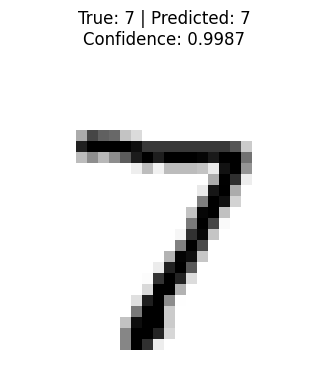

In [ ]:

print("\nDisplaying a sample prediction from the test set (by index):")
display_single_prediction(rnn, sample_index=0, X_dataset=X_test, y_dataset=y_test)

